<a href="https://colab.research.google.com/github/6poh66/FraudDetectionBlockchain/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

!unzip -q creditcardfraud.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.14GB/s]


# **Dataset Download**

In [ ]:
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip -q creditcardfraud.zip


Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
creditcardfraud.zip: Skipping, found more recently modified local copy (use --force to force download)
replace creditcard.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import SMOTE
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix
import shap

# **Dataset Load**

In [ ]:
# Load Dataset
df = pd.read_csv('creditcard.csv')

# EXPLORATORY DATA ANALYSIS (EDA)
print("\nDataset Head:")
print(df.head())

print("\nDataset Info:")
df.info()

print("\nNull values:")
print(df.isnull().sum().max())


Dataset Head:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26      

# **Class Distribution**


Class Distribution (Before SMOTE):
Class
0    284315
1       492
Name: count, dtype: int64


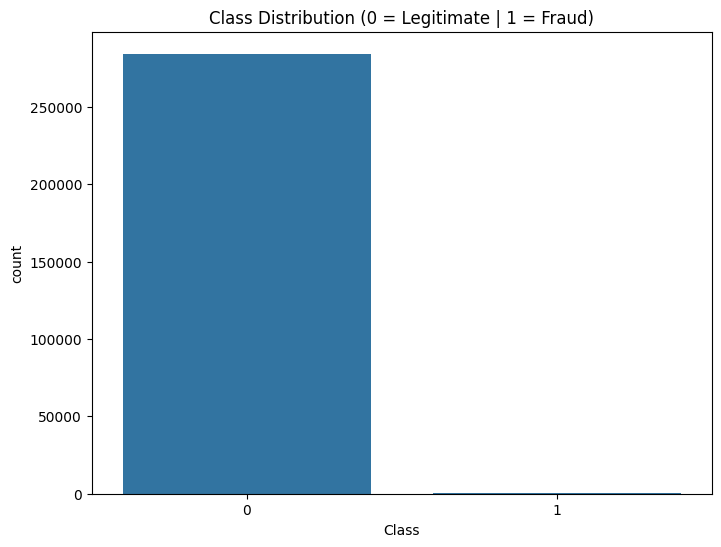

In [ ]:
print("\nClass Distribution (Before SMOTE):")
class_counts = df['Class'].value_counts()
print(class_counts)

# Visualize the class imbalance
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0 = Legitimate | 1 = Fraud)')
plt.show()

Dataset is highly imbalanced.

In [ ]:
scaler = RobustScaler()

df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# Drop the original 'Time' and 'Amount' columns
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# Separate features (X) and target (y)
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"\nOriginal training set shape: {X_train.shape}")
print(f"Original test set shape: {X_test.shape}")



Original training set shape: (199364, 30)
Original test set shape: (85443, 30)


Handling Data Imbalance in Training Set using SMOTE



Class Distribution (After SMOTE on Training Data):
Class
0    199020
1    199020
Name: count, dtype: int64


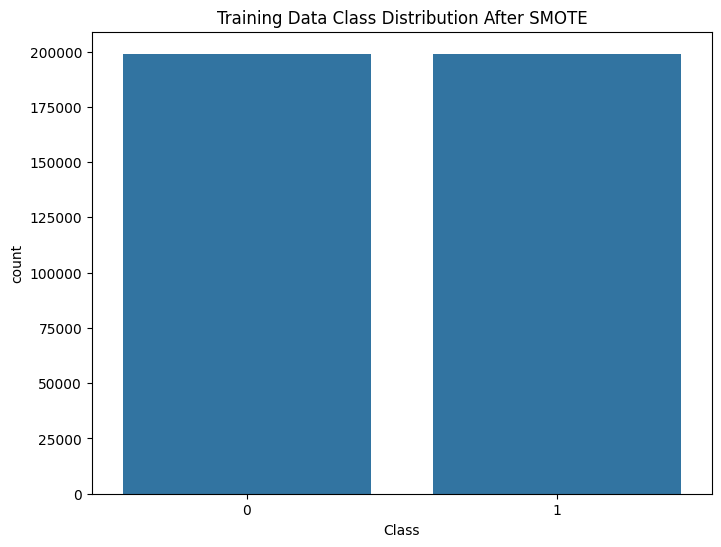

Balanced training set shape: (398040, 30)
Test set shape remains: (85443, 30)


In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\nClass Distribution (After SMOTE on Training Data):")
print(pd.Series(y_train_smote).value_counts())

# Visualize the balanced training data
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote)
plt.title('Training Data Class Distribution After SMOTE')
plt.show()


print(f"Balanced training set shape: {X_train_smote.shape}")
print(f"Test set shape remains: {X_test.shape}")


In [ ]:
#delete the old, stale model files
!rm -f fraud_model.pkl
!rm -f scaler.pkl
print("Old model and scaler files deleted.")

Old model and scaler files deleted.


# **ML Model**


--- Training Logistic Regression ---

Classification Report for Logistic Regression:
                precision    recall  f1-score   support

Legitimate (0)       1.00      0.98      0.99     85295
     Fraud (1)       0.06      0.88      0.12       148

      accuracy                           0.98     85443
     macro avg       0.53      0.93      0.55     85443
  weighted avg       1.00      0.98      0.99     85443

AUC Score: 0.9655

--- Training Decision Tree ---

Classification Report for Decision Tree:
                precision    recall  f1-score   support

Legitimate (0)       1.00      1.00      1.00     85295
     Fraud (1)       0.39      0.74      0.51       148

      accuracy                           1.00     85443
     macro avg       0.69      0.87      0.75     85443
  weighted avg       1.00      1.00      1.00     85443

AUC Score: 0.8706

--- Training Random Forest ---

Classification Report for Random Forest:
                precision    recall  f1-score   supp

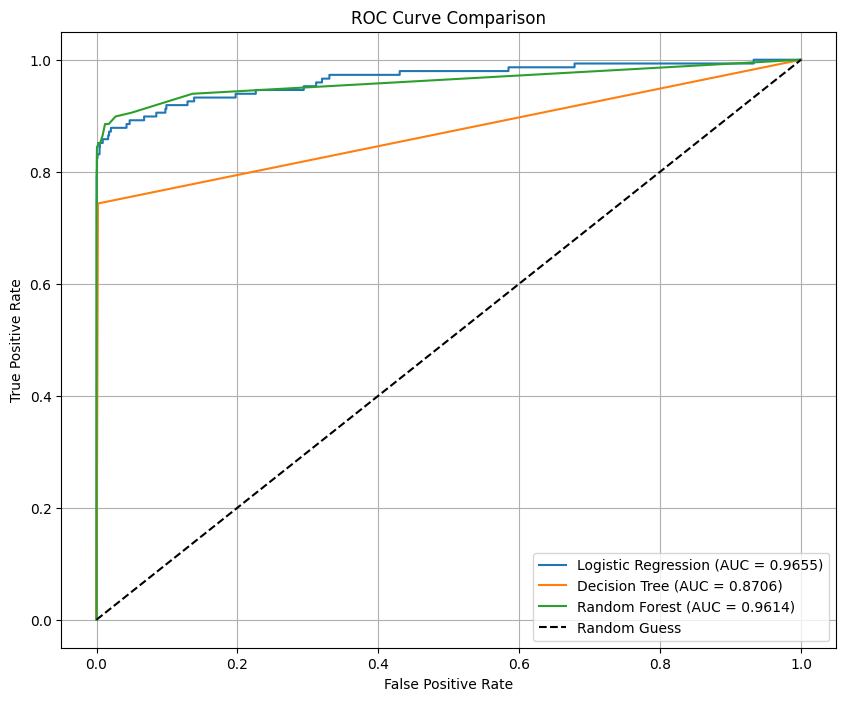

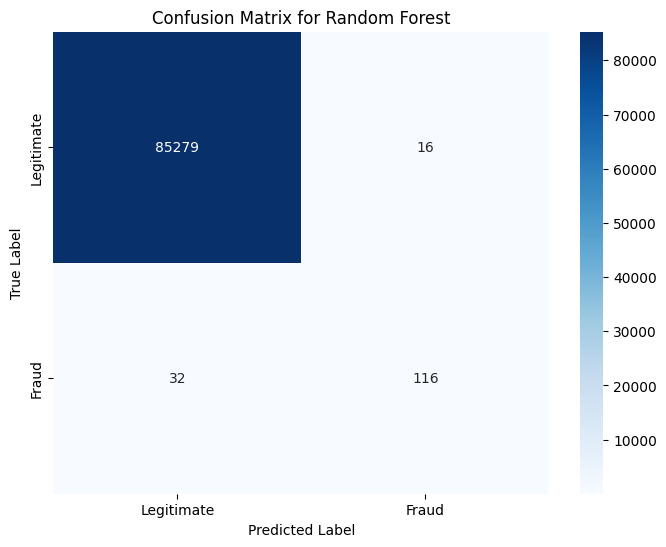

In [ ]:
#Models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42, n_jobs=-1)
}

results = {}

for model_name, model in models.items():
    print(f"\n--- Training {model_name} ---")

    # Train the model on the SMOTE-balanced data
    model.fit(X_train_smote, y_train_smote)

    # Make predictions on the original, imbalanced test set
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Evaluate performance
    print(f"\nClassification Report for {model_name}:")
    report = classification_report(y_test, y_pred, target_names=['Legitimate (0)', 'Fraud (1)'])
    print(report)

    auc_score = roc_auc_score(y_test, y_pred_proba)
    print(f"AUC Score: {auc_score:.4f}")

    # Store results for comparison
    results[model_name] = {
        'model': model,
        'report': classification_report(y_test, y_pred, output_dict=True),
        'auc': auc_score,
        'y_pred_proba': y_pred_proba
    }



#Model Performance Comparison
plt.figure(figsize=(10, 8))
for model_name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {result['auc']:.4f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid()
plt.show()


#Confusion Matrix
best_model_name = "Random Forest"
y_pred_best = results[best_model_name]['model'].predict(X_test)
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraud'], yticklabels=['Legitimate', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix for {best_model_name}')
plt.show()



# Saving the Model

In [ ]:
try:
    with open('fraud_model.pkl', 'wb') as f:
        pickle.dump(results['Random Forest']['model'], f)

    scaler_to_save = RobustScaler()
    scaler_to_save.fit(X_train) # Fit on the non-SMOTE training data
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler_to_save, f)

    print("Model 'fraud_model.pkl' and 'scaler.pkl' have been saved successfully.")

except NameError:
    print("\nERROR: The 'scaler' or 'X_train' object from the previous step was not found.")
    print("Please ensure you have run the data preprocessing cell successfully before this one.")

Model 'fraud_model.pkl' and 'scaler.pkl' have been saved successfully.


# **XAI**

Model and data loaded successfully.
Sample created with shape: (100, 30)
SHAP values calculated successfully!
--------------------------------------------------
Global Explanation (Feature Importance)...
Corrected SHAP values shape: (100, 30)
X_test_sample_reordered shape: (100, 30)


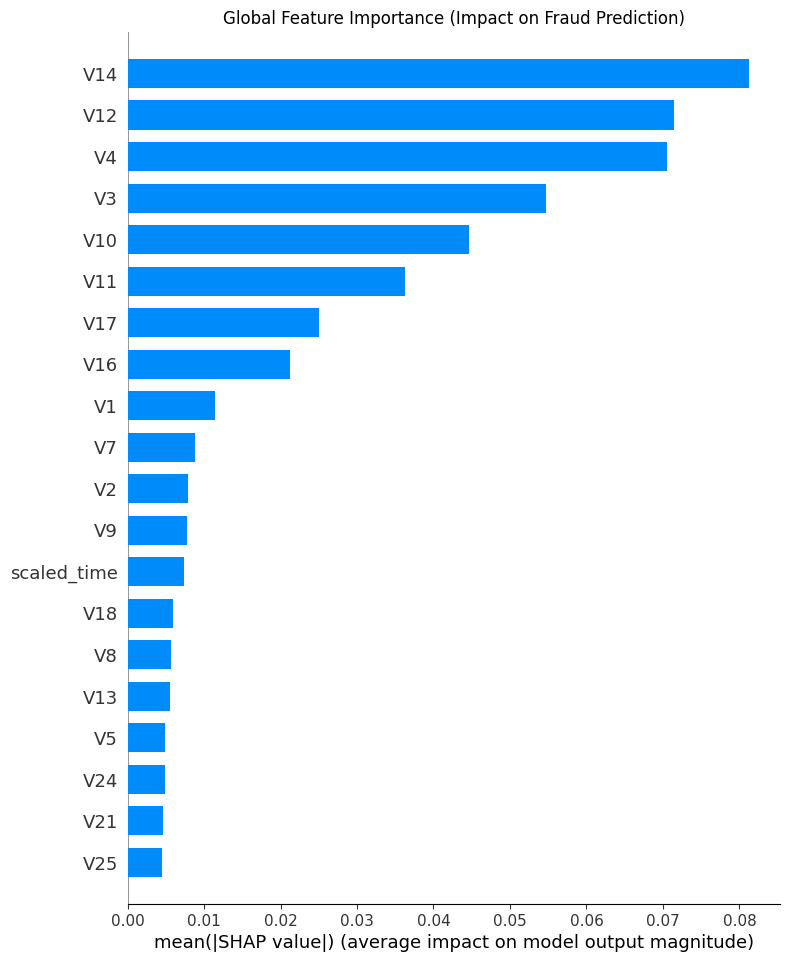


The bar chart above shows the features that have the most impact on the model's predictions for fraud, ranked from most to least important.
--------------------------------------------------

Local Explanation for a single fraudulent transaction from the sample...
Could not find a correctly predicted fraudulent transaction in this smaller sample to explain. You can try increasing the sample size or re-running.


In [ ]:
shap.initjs()

try:
    with open('fraud_model.pkl', 'rb') as f:
        model = pickle.load(f)
    print("Model and data loaded successfully.")
except FileNotFoundError:
    print("ERROR: 'fraud_model.pkl' not found.")


#SHAP EXPLAINER

X_test_sample = X_test.sample(n=100, random_state=42)
print(f"Sample created with shape: {X_test_sample.shape}")

explainer = shap.TreeExplainer(model)
shap_values_sample = explainer.shap_values(X_test_sample)

print("SHAP values calculated successfully!")
print("-" * 50)


#GLOBAL EXPLANATION PLOT
print("Global Explanation (Feature Importance)...")

# column order of the sample matches the model's training data
try:
    X_test_sample_reordered = X_test_sample[model.feature_names_in_]
except AttributeError:
    print("Using a fallback method for feature names.")
    X_test_sample_reordered = X_test_sample

shap_values_for_fraud = shap_values_sample[:, :, 1]

print("Corrected SHAP values shape:", shap_values_for_fraud.shape)
print("X_test_sample_reordered shape:", X_test_sample_reordered.shape)

shap.summary_plot(shap_values_for_fraud, X_test_sample_reordered, plot_type="bar", show=False)
plt.title("Global Feature Importance (Impact on Fraud Prediction)")
plt.show()

print("\nThe bar chart above shows the features that have the most impact on the model's predictions for fraud, ranked from most to least important.")
print("-" * 50)


#LOCAL EXPLANATION PLOT
print("\nLocal Explanation for a single fraudulent transaction from the sample...")

# True labels corresponding to our sample
y_test_sample = y_test.loc[X_test_sample.index]

# Predictions on our sample
y_pred_sample = model.predict(X_test_sample)

# Correctly predicted fraud instance within the sample
correctly_predicted_fraud_indices_sample = X_test_sample.index[np.where((y_test_sample == 1) & (y_pred_sample == 1))[0]]

if len(correctly_predicted_fraud_indices_sample) > 0:
    instance_index = correctly_predicted_fraud_indices_sample[0]
    loc_in_sample = X_test_sample.index.get_loc(instance_index)

    print(f"\nExplaining prediction for instance at original index: {instance_index} (a confirmed fraudulent transaction)")

    shap.force_plot(
        explainer.expected_value[1],
        shap_values_sample[loc_in_sample, :, 1],
        X_test_sample_reordered.loc[instance_index, :],
        matplotlib=True,
        show=False
    )
    plt.title("Local Explanation for a Fraudulent Transaction")
    plt.show()
    print("In the plot above: Features in RED push the prediction HIGHER (towards fraud). Features in BLUE push it LOWER (towards legitimate).")

else:
    print("Could not find a correctly predicted fraudulent transaction in this smaller sample to explain. You can try increasing the sample size or re-running.")